# Initial Setup

In [1]:
# --- Environment Setup ---
# Run this cell if you are using Google Colab or a fresh environment without dependencies installed.
# If you are running locally with the Conda environment set up (per README), you can skip this.

try:
    import qiskit
    import qiskit_finance
    print("Libraries are already installed.")
except ImportError:
    print("Libraries not found. Installing now... (This may take a few minutes)")
    %pip install qiskit qiskit-finance qiskit-algorithms qiskit-aer qiskit-ibm-runtime matplotlib pylatexenc python-dotenv
    print("Installation complete. Please restart the runtime/kernel if needed.")

Libraries are already installed.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import StatevectorSampler, BackendSamplerV2
from qiskit.circuit.library import LinearAmplitudeFunctionGate, RYGate
from qiskit.quantum_info import Statevector

from qiskit_finance.circuit.library import LogNormalDistribution
from qiskit_finance.applications.estimation import EuropeanCallPricing, EuropeanCallDelta

from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2

from dotenv import load_dotenv
load_dotenv()

import os
import json
from pathlib import Path

In [3]:
spot_price = 2.0
strike_price = 1.896
volatility = 0.4
risk_free_rate = 0.05
time_to_maturity = 40 / 365

DEFAULT_SHOTS = 8192
BACKEND_NAME = "ibm_fez"

In [4]:
# ===== Persistent results logging (PRICE only) =====
# - Logs to memory (PRICE_LOG) and appends to results/summary_prices.csv + .jsonl
# - Analysis can load from files if variables are absent (no reruns needed)
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

JSONL_PATH = RESULTS_DIR / "summary_prices.jsonl"

PRICE_LOG = []  # in-memory rows (optional)

def record_result(method: str, estimate: float, ci_low=None, ci_high=None, **meta):
    """
    Append one price result to memory and to disk.
    """
    row = {
        "Method": method,
        "Estimate": float(estimate),
        "CI Low": float(ci_low) if ci_low is not None else np.nan,
        "CI High": float(ci_high) if ci_high is not None else np.nan,
    }
    row.update(meta)

    # normalize CI bounds if swapped
    if np.isfinite(row["CI Low"]) and np.isfinite(row["CI High"]) and row["CI Low"] > row["CI High"]:
        row["CI Low"], row["CI High"] = row["CI High"], row["CI Low"]

    PRICE_LOG.append(row)

    # append JSONL (one JSON object per line)
    with open(JSONL_PATH, "a", encoding="utf-8") as f:
        f.write(json.dumps(row, ensure_ascii=False) + "\n")

def load_results_from_files():
    """
    Load results from disk:
      - prefer CSV if present
      - fall back to JSONL
    Returns a DataFrame (may be empty).
    """
    if JSONL_PATH.exists():
        rows = []
        with open(JSONL_PATH, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if line:
                    rows.append(json.loads(line))
        return pd.DataFrame(rows)
    return pd.DataFrame(columns=["Method", "Estimate", "CI Low", "CI High"])

def get_results_df():
    """
    If in-memory log has rows, use it; otherwise load from disk.
    """
    if len(PRICE_LOG):
        return pd.DataFrame(PRICE_LOG)
    return load_results_from_files()

def clear_results_files():
    """
    Deletes the persisted result files. Use if you want to start fresh.
    """
    if JSONL_PATH.exists():
        JSONL_PATH.unlink()
    PRICE_LOG.clear()


# Classical Monte Carlo Simulation

To establish a benchmark, we first implement and run a classical Monte Carlo simulation

In [5]:
def run_classical_monte_carlo(num_samples):
  Z = np.random.standard_normal(num_samples)
  S_T = spot_price * np.exp((risk_free_rate - 0.5 * volatility**2) * time_to_maturity + volatility * np.sqrt(time_to_maturity) * Z)

  payoffs = np.maximum(0, S_T - strike_price)

  # Average the payoffs and discount back to today
  # Price = exp(-rT) * Average(Payoffs)
  option_price = np.exp(-risk_free_rate * time_to_maturity) * np.mean(payoffs)

  return option_price

In [6]:
M_benchmark = 10000000
print(f"Running high-precision benchmark (M={M_benchmark:<7,})...")

exact_value = run_classical_monte_carlo(M_benchmark)
record_result(method="Classical MC (benchmark)", estimate=exact_value, samples=M_benchmark)

print(f"Exact Value (Benchmark): ${exact_value:.4f}")

M_values = [10, 100, 1000, 10000, 100000, 1000000]

classical_prices = []
classical_errors = []

print("\n--- Classical Convergence Results ---")
print(f"{'Samples (M)':<15} {'Estimated Price':<20} {'Error'}")
print("-" * 45)

for M in M_values:
    price_estimate = run_classical_monte_carlo(M)
    
    error = abs(price_estimate - exact_value)
    
    classical_prices.append(price_estimate)
    classical_errors.append(error)
    
    print(f"{M:<15,} ${price_estimate:<19.4f} {error:.5f}")

print("-" * 45)

Running high-precision benchmark (M=10,000,000)...
Exact Value (Benchmark): $0.1696

--- Classical Convergence Results ---
Samples (M)     Estimated Price      Error
---------------------------------------------
10              $0.0922              0.07745
100             $0.1566              0.01302
1,000           $0.1685              0.00115
10,000          $0.1677              0.00192
100,000         $0.1707              0.00103
1,000,000       $0.1697              0.00009
---------------------------------------------


# Quantum Approach 1: Building the Circuit Step-by-Step

In [7]:
num_uncertainty_qubits = 3

mu = (risk_free_rate - 0.5 * volatility**2) * time_to_maturity + np.log(spot_price)
sigma = volatility * np.sqrt(time_to_maturity)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

uncertainty_model = LogNormalDistribution(num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high))

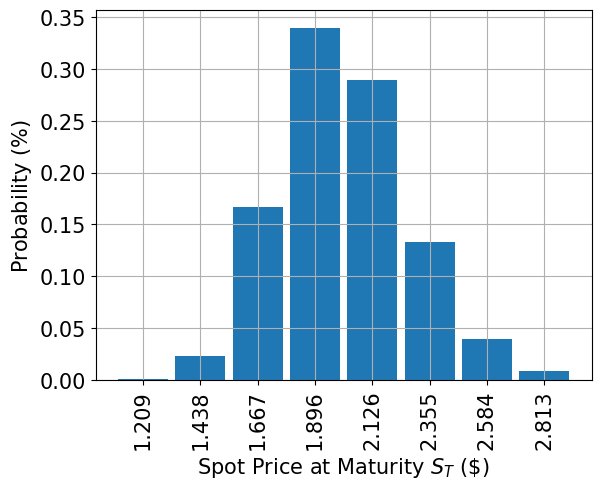

In [8]:
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.bar(x, y, width=0.2)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.show()

In [9]:
c_approx = 0.25

breakpoints = [low, strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price
european_call_objective = LinearAmplitudeFunctionGate(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)

num_qubits = european_call_objective.num_qubits
print(num_qubits, num_uncertainty_qubits)
european_call = QuantumCircuit(num_qubits)
european_call.append(uncertainty_model, range(num_uncertainty_qubits))
european_call.append(european_call_objective, range(num_qubits))

5 3


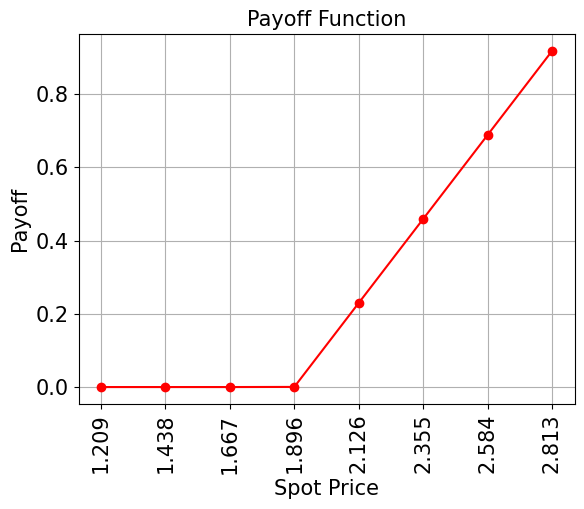

In [10]:
# plot exact payoff function (evaluated on the grid of the uncertainty model)
x = uncertainty_model.values
y = np.maximum(0, x - strike_price)
plt.plot(x, y, "ro-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("Spot Price", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [11]:
exact_value = np.dot(uncertainty_model.probabilities, y)
exact_delta = sum(uncertainty_model.probabilities[x >= strike_price])
print("exact expected value:\t%.4f" % exact_value)
print("exact delta value:   \t%.4f" % exact_delta)

exact expected value:	0.1623
exact delta value:   	0.8098


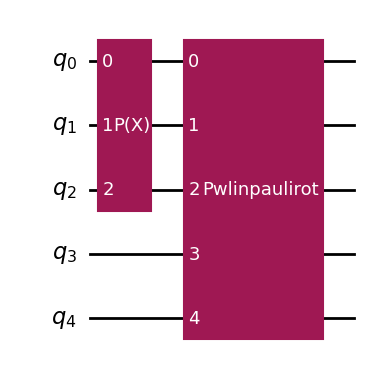

In [12]:
european_call.decompose().draw(output='mpl');

In [13]:
epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(
    state_preparation=european_call,
    objective_qubits=[3],
    post_processing=european_call_objective.post_processing,
)

ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=StatevectorSampler()
)

In [14]:
result = ae.estimate(problem)

In [15]:
conf_int = np.array(result.confidence_interval_processed)
record_result(
    method="IAE (StatevectorSampler, ideal, manually constructed circuit)",
    estimate=result.estimation_processed,
    ci_low=conf_int[0],
    ci_high=conf_int[1],
    circuit_width=european_call.num_qubits,
)

print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (result.estimation_processed))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.1623
Estimated value:    	0.1676
Confidence interval:	[0.1611, 0.1740]


# Approach 2: Using Qiskit Finance Application Classes

In [16]:
european_call_pricing = EuropeanCallPricing(
    num_state_qubits=num_uncertainty_qubits,
    strike_price=strike_price,
    rescaling_factor=c_approx,
    bounds=(low, high),
    uncertainty_model=uncertainty_model,
)

In [17]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

problem = european_call_pricing.to_estimation_problem()
ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=StatevectorSampler()
)
result = ae.estimate(problem)

conf_int = np.array(result.confidence_interval_processed)
record_result("IAE (StatevectorSampler, ideal, library circuit)", european_call_pricing.interpret(result), conf_int[0], conf_int[1], circuit_width=problem.state_preparation.num_qubits)
print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (european_call_pricing.interpret(result)))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.1623
Estimated value:    	0.1669
Confidence interval:	[0.1595, 0.1743]


# Running QAE on quantum hardware and AER Simulator

In [18]:
# Shared sampler helper (externalized to keep notebook lean)
from utils import SamplerWithShots, sampler_with_forced_shots

api_token = os.getenv("IBM_QUANTUM_TOKEN")
instance = os.getenv("IBM_QUANTUM_INSTANCE")

if not api_token:
    raise RuntimeError("IBM_QUANTUM_TOKEN not found.")

if not QiskitRuntimeService.saved_accounts():
    kwargs = dict(token=api_token, channel="ibm_quantum_platform", set_as_default=True)
    if instance:
        kwargs["instance"] = instance
    QiskitRuntimeService.save_account(**kwargs)

service = QiskitRuntimeService()

# 3-qubit paper-style runs

In [19]:
# ===== Common setup (3q IAE/direct) + shared helpers =====

from utils import (
    CountingSampler,
    build_3q_components,
    make_3q_problem,
    run_iae_experiment,
)

# --- Required globals (should already exist earlier in your notebook) ---
# spot_price, strike_price, volatility, risk_free_rate, time_to_maturity
# mu, sigma, low, high
_missing = [k for k in ["spot_price","strike_price","volatility","risk_free_rate","time_to_maturity","mu","sigma","low","high"] if k not in globals()]
if _missing:
    raise RuntimeError(f"Missing required variables in notebook globals: {_missing}")

# --- IBM account/service (used by both Aer-from-backend and hardware) ---
IBM_TOKEN = os.getenv("IBM_QUANTUM_TOKEN")
IBM_INSTANCE = os.getenv("IBM_QUANTUM_INSTANCE")
if not IBM_TOKEN:
    raise RuntimeError("Set IBM_QUANTUM_TOKEN (or IBM_QUANTUM_KEY) in your environment/.env")

if not QiskitRuntimeService.saved_accounts():
    kwargs = dict(token=IBM_TOKEN, channel="ibm_quantum_platform", set_as_default=True)
    if IBM_INSTANCE:
        kwargs["instance"] = IBM_INSTANCE
    QiskitRuntimeService.save_account(**kwargs)

service = QiskitRuntimeService()

BACKEND_NAME = "ibm_fez"
SHOTS_3Q = DEFAULT_SHOTS
C_APPROX = 0.25           # paper uses c = 0.25

components_3q = build_3q_components(
    mu=mu,
    sigma=sigma,
    low=low,
    high=high,
    strike_price=strike_price,
    risk_free_rate=risk_free_rate,
    time_to_maturity=time_to_maturity,
    c_approx=C_APPROX,
)
A3_3q = components_3q.measured
post_process_3q = components_3q.post_process
problem_3q = make_3q_problem(components_3q)
p1_ideal_3q = components_3q.p1_ideal
objective_qubit_3q = components_3q.objective_qubit

print(f"[3q setup] width={A3_3q.num_qubits}, ideal p(obj=1)={p1_ideal_3q:.6f}, shots={SHOTS_3Q}")




[3q setup] width=3, ideal p(obj=1)=0.353875, shots=8192


In [20]:
# ===== 3q IAE (Noisy Aer + optional hardware) =====
RUN_3Q_NOISY = True
RUN_3Q_HW = True
EPSILON_3Q = float(os.getenv("EPSILON_3Q", "0.15"))

backend_for_noise = service.backend(BACKEND_NAME)
print(f"[3q] backend for noise model: {backend_for_noise.name}")

sim_backend = AerSimulator.from_backend(backend_for_noise)
pm_noisy = generate_preset_pass_manager(backend=sim_backend, optimization_level=1)
A3_t_noisy = pm_noisy.run(A3_3q)

class _EstimationToPrice:
    def __init__(self, post_process):
        self.post_process = post_process
    def interpret(self, res):
        val = getattr(res, "estimation_processed", None)
        if val is None:
            val = getattr(res, "estimation", None)
        return float(val) if val is not None else float("nan")

pricing_3q = _EstimationToPrice(post_process_3q)
target_price = post_process_3q(p1_ideal_3q)
print(f"[3q setup] width={A3_3q.num_qubits}, ideal p(obj=1)={p1_ideal_3q:.6f}, target price=${target_price:.6f}, shots={SHOTS_3Q}")

if RUN_3Q_NOISY:
    res_iae = run_iae_experiment(
        backend=sim_backend,
        pricing=pricing_3q,
        problem=problem_3q,
        shots=SHOTS_3Q,
        epsilon=EPSILON_3Q,
        label=f"3Q IAE (NOISY AER, {backend_for_noise.name})",
        sampler_factory=lambda b: sampler_with_forced_shots(b, SHOTS_3Q),
        pm=pm_noisy,
        log_method=f"3Q IAE (Noisy Aer, {backend_for_noise.name})",
        log_fn=record_result,
        use_counting_sampler=True,
        alpha=alpha,
    )
    ci_lo, ci_hi = res_iae["ci"]
    est_amp = getattr(res_iae["result"], "estimation", np.nan)
    est_amp_proc = getattr(res_iae["result"], "estimation_processed", np.nan)
    print("" + "="*40)
    print("3Q IAE (NOISY AER)")
    print("="*40)
    print(f"Raw amp estimate:    {est_amp:.6f} (processed {est_amp_proc:.6f})")
    print(f"Estimated Price:     ${res_iae['estimate']:.6f}")
    print(f"Approx CI (95%):     [${ci_lo:.6f}, ${ci_hi:.6f}]")
    print("="*40)

if RUN_3Q_HW:
    backend_hw = service.backend(BACKEND_NAME)
    pm_hw = generate_preset_pass_manager(backend=backend_hw, optimization_level=1)
    A3_t_hw = pm_hw.run(A3_3q)
    res_hw = run_iae_experiment(
        backend=backend_hw,
        pricing=pricing_3q,
        problem=problem_3q,
        shots=SHOTS_3Q,
        epsilon=EPSILON_3Q,
        label=f"3Q IAE (HARDWARE, {backend_hw.name})",
        sampler_factory=lambda b: sampler_with_forced_shots(b, SHOTS_3Q),
        pm=pm_hw,
        log_method=f"3Q IAE (IBM Hardware, {backend_hw.name})",
        log_fn=record_result,
        use_counting_sampler=True,
        alpha=alpha,
    )
    ci_lo, ci_hi = res_hw["ci"]
    est_amp = getattr(res_hw["result"], "estimation", np.nan)
    est_amp_proc = getattr(res_hw["result"], "estimation_processed", np.nan)
    print("" + "="*40)
    print(f"3Q IAE (HARDWARE, {backend_hw.name})")
    print("="*40)
    print(f"Raw amp estimate:    {est_amp:.6f} (processed {est_amp_proc:.6f})")
    print(f"Estimated Price:     ${res_hw['estimate']:.6f}")
    print(f"Approx CI (95%):     [${ci_lo:.6f}, ${ci_hi:.6f}]")
    print("="*40)




[3q] backend for noise model: ibm_fez
[3q setup] width=3, ideal p(obj=1)=0.353875, target price=$0.189543, shots=8192
3Q IAE (NOISY AER)
Raw amp estimate:    0.386533 (processed 0.249133)
Estimated Price:     $0.249133
Approx CI (95%):     [$0.225525, $0.272741]
3Q IAE (HARDWARE, ibm_fez)
Raw amp estimate:    0.382994 (processed 0.242677)
Estimated Price:     $0.242677
Approx CI (95%):     [$0.219109, $0.266245]


# 5-qubit runs

In [21]:
# ---- build simplified 2-qubit problem for NISQ ----
hw_qubits = 2
hw_epsilon = 0.1
alpha = 0.05
shots = DEFAULT_SHOTS

low_f = float(np.asarray(low))
high_f = float(np.asarray(high))

hw_model = LogNormalDistribution(hw_qubits, mu=mu, sigma=sigma**2, bounds=(low_f, high_f))
hw_pricing = EuropeanCallPricing(
    num_state_qubits=hw_qubits,
    strike_price=strike_price,
    rescaling_factor=0.25,
    bounds=(low_f, high_f),
    uncertainty_model=hw_model,
)
hw_problem = hw_pricing.to_estimation_problem()

required_qubits = hw_problem.state_preparation.num_qubits
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=required_qubits)


In [22]:

# --- 5-qubit IAE (noisy simulator + optional hardware) ---
RUN_5Q_SIM = True
RUN_5Q_HW = True  # set to 1 to submit hardware job

print(f"Estimated circuit width (qubits): {required_qubits}")

# ---- Noisy simulator derived from backend properties ----
if RUN_5Q_SIM:
    try:
        sim_backend = AerSimulator.from_backend(backend)
        sim_label = getattr(sim_backend, "name", "aer")
        print(f"Local simulator: {sim_label} (device-derived noise)")
    except Exception as e:
        sim_backend = AerSimulator()
        print(f"Local simulator: AerSimulator() fallback (reason: {e})")

    pm_sim = generate_preset_pass_manager(backend=sim_backend, optimization_level=1)
    print("Running IAE on noisy local simulator...")
    res_sim = run_iae_experiment(
        backend=sim_backend,
        pricing=hw_pricing,
        problem=hw_problem,
        shots=shots,
        epsilon=hw_epsilon,
        label=f"LOCAL (AER) RESULT ({getattr(sim_backend, 'name', 'aer')})",
        sampler_factory=lambda b: SamplerWithShots(BackendSamplerV2(backend=b), shots),
        pm=pm_sim,
        log_method=f"IAE (5q) Noisy Aer ({backend.name})",
    )

    aer_est_price = res_sim["estimate"]
    aer_ci_low, aer_ci_high = res_sim["ci"]

    print("" + "=" * 40)
    print("LOCAL (AER) RESULT")
    print("=" * 40)
    print(f"Estimated Price:     ${aer_est_price:.6f}")
    print(f"Confidence Interval: [${aer_ci_low:.6f}, ${aer_ci_high:.6f}]")
    print("=" * 40)

    record_result(
        method=f"IAE (5q) Noisy Aer ({backend.name})",
        estimate=aer_est_price,
        ci_low=aer_ci_low,
        ci_high=aer_ci_high,
        shots=int(shots),
        circuit_width=int(required_qubits),
    )

# ---- Optional hardware execution ----
if RUN_5Q_HW:
    print(f"Selected Backend: {backend.name}")
    print(f"Status: {backend.status().to_dict()}")

    pm_hw = generate_preset_pass_manager(backend=backend, optimization_level=1)
    print("Submitting IAE job to IBM Quantum... (queues like a standard job)")
    res_hw = run_iae_experiment(
        backend=backend,
        pricing=hw_pricing,
        problem=hw_problem,
        shots=shots,
        epsilon=hw_epsilon,
        label=f"HARDWARE RESULT ({backend.name})",
        sampler_factory=lambda b: sampler_with_forced_shots(b, shots),
        pm=pm_hw,
        log_method=f"IAE (5q) IBM Hardware ({backend.name})",
    )

    hw_est_price = res_hw["estimate"]
    hw_ci_low, hw_ci_high = res_hw["ci"]

    print("" + "=" * 40)
    print(f"HARDWARE RESULT ({backend.name})")
    print("=" * 40)
    print(f"Estimated Price:     ${hw_est_price:.6f}")
    print(f"Confidence Interval: [${hw_ci_low:.6f}, ${hw_ci_high:.6f}]")
    print("=" * 40)
    print("Note: deviation vs ideal is expected due to NISQ noise.")

    record_result(
        method=f"IAE (5q) IBM Hardware ({backend.name})",
        estimate=hw_est_price,
        ci_low=hw_ci_low,
        ci_high=hw_ci_high,
        shots=int(shots),
        circuit_width=int(required_qubits),
    )


Estimated circuit width (qubits): 5
Local simulator: aer_simulator_from(ibm_torino) (device-derived noise)
Running IAE on noisy local simulator...
LOCAL (AER) RESULT
Estimated Price:     $0.209294
Confidence Interval: [$0.178976, $0.239612]
Selected Backend: ibm_torino
Status: {'backend_name': 'ibm_torino', 'backend_version': '', 'operational': True, 'pending_jobs': 0, 'status_msg': 'active'}
Submitting IAE job to IBM Quantum... (queues like a standard job)
HARDWARE RESULT (ibm_torino)
Estimated Price:     $0.246916
Confidence Interval: [$0.216398, $0.277435]
Note: deviation vs ideal is expected due to NISQ noise.


# Data plotting and analysis

Baseline: 0.1696360207397794


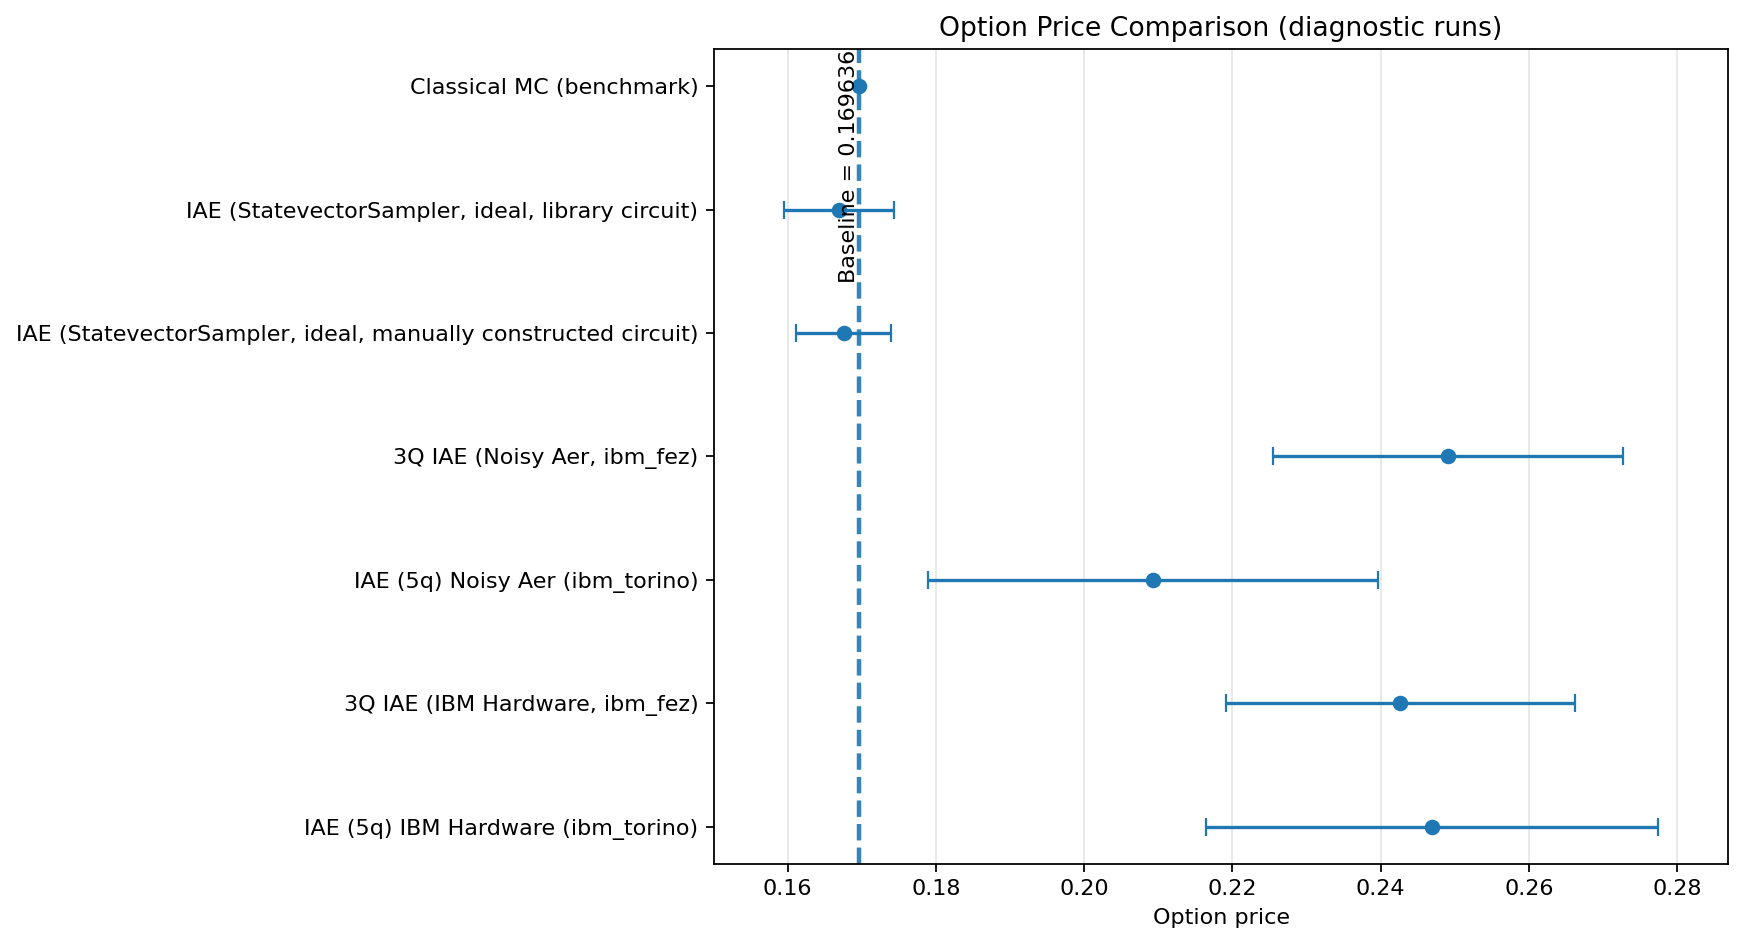

Saved: results/price_forest_with_baseline.png


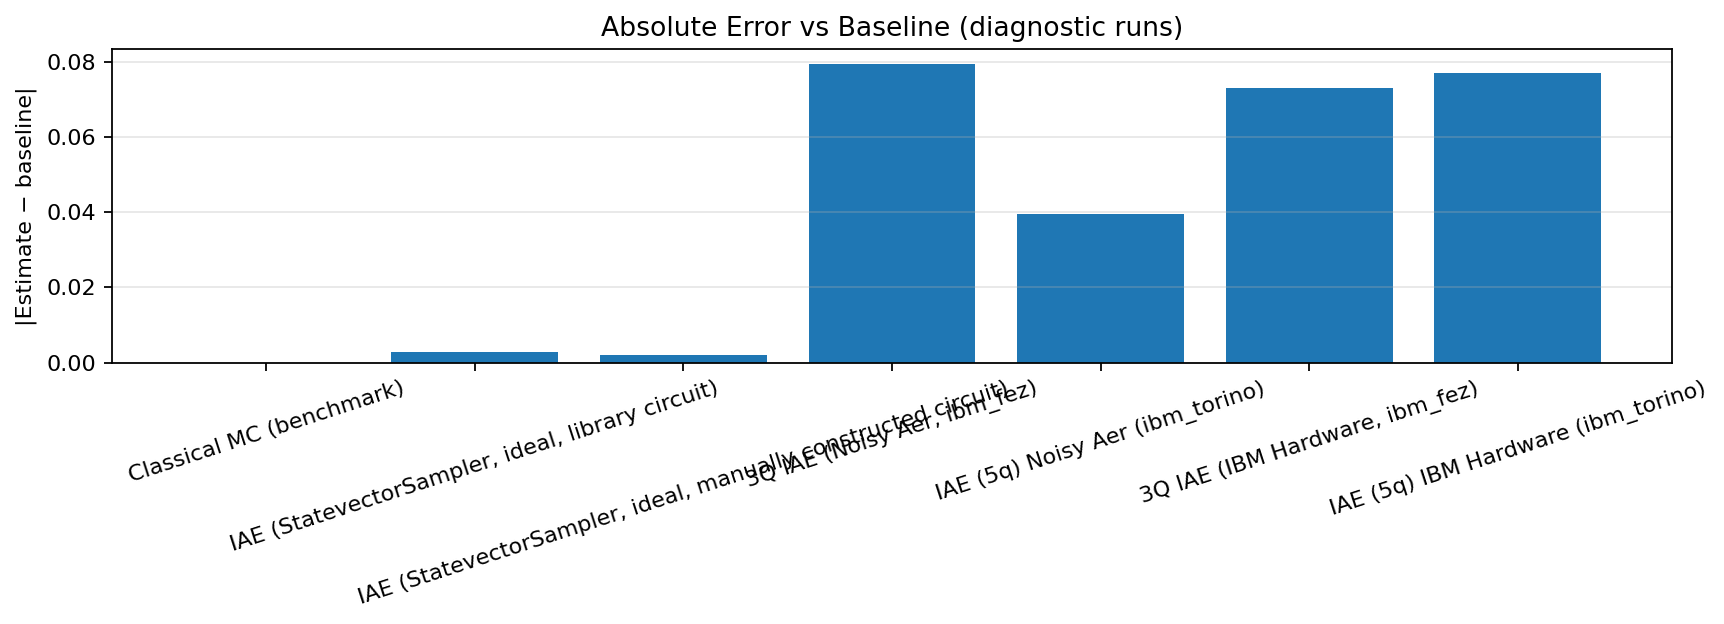

Saved: results/abs_error_vs_baseline.png


In [23]:
# ===== CELL A: diagnostics plots (forest + abs error) from JSONL =====
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
JSONL_PATH = RESULTS_DIR / "summary_prices.jsonl"

def load_jsonl(path: Path) -> pd.DataFrame:
    if not path.exists():
        return pd.DataFrame()
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line:
                rows.append(json.loads(line))
    return pd.DataFrame(rows)

df = load_jsonl(JSONL_PATH)
if df.empty:
    raise RuntimeError("No JSONL results found at results/summary_prices.jsonl")

# Normalize core columns
for col in ["Method","Estimate","CI Low","CI High","family","backend","budget","shots","samples","epsilon","run_tag"]:
    if col not in df.columns:
        df[col] = np.nan

for col in ["Estimate","CI Low","CI High","budget","shots","samples","epsilon"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Swap CI if reversed
swap = np.isfinite(df["CI Low"]) & np.isfinite(df["CI High"]) & (df["CI Low"] > df["CI High"])
df.loc[swap, ["CI Low","CI High"]] = df.loc[swap, ["CI High","CI Low"]].to_numpy()

# Baseline: prefer Classical MC (benchmark)
m_base = df["Method"].astype(str).str.contains("Classical MC (benchmark)", case=False, na=False, regex=False)
if m_base.any():
    baseline = float(df.loc[m_base, "Estimate"].dropna().iloc[-1])
elif "exact_value" in globals() and np.isfinite(globals()["exact_value"]):
    baseline = float(globals()["exact_value"])
else:
    raise RuntimeError("Baseline not found. Log 'Classical MC (benchmark)' or define exact_value.")
print("Baseline:", baseline)

# Keep only the "first run / diagnostic" rows:
# keep latest per Method (for clean forest plot)
df_rep = df.dropna(subset=["Estimate"]).copy()
df_rep["ts"] = df_rep.get("timestamp", np.nan)  # if you logged timestamp
df_rep["run_tag"] = df_rep["run_tag"].astype(str)
df_rep = df_rep.groupby("Method", as_index=False).tail(1)

def _sort_key(m):
    s = str(m).lower()
    if "benchmark" in s: return (0, s)
    if "statevector" in s: return (1, s)
    if "direct" in s and "3q" in s: return (2, s)
    if "iae" in s and "noisy" in s: return (3, s)
    if "iae" in s and ("hw" in s or "hardware" in s): return (4, s)
    return (5, s)

df_rep = df_rep.sort_values(by="Method", key=lambda s: s.map(_sort_key)).reset_index(drop=True)

# ---------- Plot 1: forest plot ----------
fig, ax = plt.subplots(figsize=(11, 6), dpi=160)

y = np.arange(len(df_rep))[::-1]
x = df_rep["Estimate"].to_numpy()
lo = df_rep["CI Low"].to_numpy()
hi = df_rep["CI High"].to_numpy()

mask = np.isfinite(lo) & np.isfinite(hi)
err_left = x - lo
err_right = hi - x
mask2 = mask & (err_left >= 0) & (err_right >= 0)

ax.scatter(x, y)
if mask2.any():
    ax.errorbar(x[mask2], y[mask2], xerr=np.vstack([err_left[mask2], err_right[mask2]]),
                fmt="none", capsize=4)

# xlim includes baseline + CIs
xmin_candidates = [np.nanmin(x), baseline]
xmax_candidates = [np.nanmax(x), baseline]
if np.isfinite(lo).any(): xmin_candidates.append(np.nanmin(lo))
if np.isfinite(hi).any(): xmax_candidates.append(np.nanmax(hi))
xmin = float(np.nanmin(xmin_candidates))
xmax = float(np.nanmax(xmax_candidates))
pad = 0.08 * (xmax - xmin + 1e-12)
ax.set_xlim(xmin - pad, xmax + pad)

ax.axvline(baseline, linestyle="--", linewidth=2, alpha=0.9)
ax.text(baseline, ax.get_ylim()[1], f"Baseline = {baseline:.6f}", rotation=90, va="top", ha="right")

ax.set_yticks(y)
ax.set_yticklabels(df_rep["Method"].tolist())
ax.set_xlabel("Option price")
ax.set_title("Option Price Comparison (diagnostic runs)")
ax.grid(True, axis="x", alpha=0.3)
fig.tight_layout()
out1 = RESULTS_DIR / "price_forest_with_baseline.png"
fig.savefig(out1, dpi=220, bbox_inches="tight")
plt.show()
print("Saved:", out1)

# ---------- Plot 2: abs error bar ----------
fig2, ax2 = plt.subplots(figsize=(11, 4), dpi=160)
errs = np.abs(df_rep["Estimate"].to_numpy() - baseline)
ax2.bar(df_rep["Method"].astype(str).tolist(), errs)
ax2.set_ylabel("|Estimate − baseline|")
ax2.set_title("Absolute Error vs Baseline (diagnostic runs)")
ax2.tick_params(axis="x", rotation=18)
ax2.grid(True, axis="y", alpha=0.3)
fig2.tight_layout()
out2 = RESULTS_DIR / "abs_error_vs_baseline.png"
fig2.savefig(out2, dpi=220, bbox_inches="tight")
plt.show()
print("Saved:", out2)


In [34]:

# =========================
# Convergence sweeps: Classical MC vs Quantum IAE (3q + 5q, ideal + noisy)
# Outputs: results/convergence_classical_vs_iae.jsonl
#
# Assumes these already exist in your notebook:
#   - BACKEND_NAME, service
#   - hw_problem, hw_pricing, required_qubits (5q)
#   - problem_3q, pricing_3q (from 3q setup)
#   - run_classical_monte_carlo, exact_value (baseline)
# =========================
from pathlib import Path
import time, json, re
import numpy as np
from qiskit_aer import AerSimulator
from qiskit.primitives import StatevectorSampler, BackendSamplerV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from utils import (
    QueryCountingSamplerV2,
    run_iae_experiment,
)

OUT_PATH = Path("results") / "convergence_classical_vs_iae.jsonl"
OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
if OUT_PATH.exists():
    OUT_PATH.unlink()
RUN_TAG = time.strftime("%Y%m%d-%H%M%S")

# Baseline: classical benchmark (already computed earlier as exact_value)
if "exact_value" not in globals():
    M_benchmark = 1_000_000
    exact_value = run_classical_monte_carlo(M_benchmark)
    record_result(method="Classical MC (benchmark)", estimate=exact_value, samples=M_benchmark)
print(f"Classical benchmark (exact_value): ${exact_value:.6f}")

backend_for_noise = service.backend(BACKEND_NAME)

# Helpers

def _append_jsonl(path: Path, row: dict):
    with open(path, "a", encoding="utf-8") as f:
        f.write(json.dumps(row, ensure_ascii=False) + "\n")

def record_conv(method, estimate, ci_lo=np.nan, ci_hi=np.nan, **meta):
    row = dict(
        Method=str(method),
        Estimate=float(estimate),
        **({"CI Low": float(ci_lo)} if np.isfinite(ci_lo) else {}),
        **({"CI High": float(ci_hi)} if np.isfinite(ci_hi) else {}),
        timestamp=time.time(),
        run_tag=RUN_TAG,
        **meta,
    )
    _append_jsonl(OUT_PATH, row)

# Common budget grid (align lengths across classical/IAE)
COMMON_BUDGETS = [512, 1_024, 2_048, 4_096]
TRIALS = 32

# Classical Monte Carlo sweep (samples budget)
print("Running classical MC sweeps...")
for samples in COMMON_BUDGETS:
    for t in range(TRIALS):
        price = run_classical_monte_carlo(int(samples))
        record_conv(
            f"Classical MC (samples)", price, np.nan, np.nan,
            family="Classical", mode="classical", trial=t,
            budget=float(samples), budget_type="samples", samples=int(samples),
            baseline_exact=float(exact_value),
        )
print("Classical MC sweeps done.")

# Common grids for IAE (ideal + noisy) using same length as classical
IAE_GRID = [(0.32, 512), (0.20, 1_024), (0.12, 2_048), (0.08, 4_096)]

# ---- 3-qubit: ideal (statevector) + noisy (device-derived) ----
sim_backend_3q_noisy = AerSimulator.from_backend(backend_for_noise)
pm_3q_noisy = generate_preset_pass_manager(backend=sim_backend_3q_noisy, optimization_level=1)

sv_sampler = StatevectorSampler()
pm_identity = None  # not needed for statevector

print("Running 3q IAE sweeps (ideal statevector)...")
for eps, forced_shots in IAE_GRID:
    eps = float(eps)
    forced_shots = int(forced_shots)
    for t in range(TRIALS):
        wrappers = []
        def _sv_sampler_factory(_):
            w = QueryCountingSamplerV2(sv_sampler, default_shots=forced_shots)
            wrappers.append(w)
            return w

        res = run_iae_experiment(
            backend=sv_sampler,
            pricing=pricing_3q,
            problem=problem_3q,
            shots=forced_shots,
            epsilon=eps,
            label="IAE-3Q (ideal)",
            sampler_factory=_sv_sampler_factory,
            pm=pm_identity,
            use_counting_sampler=False,
            log_method=None,
            log_fn=None,
            alpha=alpha,
        )

        ci_lo, ci_hi = res["ci"]
        a_calls = float(sum(w.a_calls for w in wrappers))
        unknown = int(sum(w.unknown_power_circuits for w in wrappers))
        max_power = int(max([w.max_power for w in wrappers], default=0))

        record_conv(
            "IAE-3Q (ideal)", res["estimate"], ci_lo, ci_hi,
            family="IAE-3Q-ideal", mode="ideal", trial=t,
            epsilon=eps, shots=forced_shots, circuit_width=3,
            budget=a_calls, budget_type="A_calls",
            baseline_exact=float(exact_value),
            iae_max_power=max_power, iae_unknown_power_circuits=unknown,
        )

print("Running 3q IAE sweeps (noisy Aer)...")
for eps, forced_shots in IAE_GRID:
    eps = float(eps)
    forced_shots = int(forced_shots)
    for t in range(TRIALS):
        wrappers = []
        def _iae_sampler_factory(_):
            w = QueryCountingSamplerV2(BackendSamplerV2(backend=sim_backend_3q_noisy), default_shots=forced_shots)
            wrappers.append(w)
            return w

        res = run_iae_experiment(
            backend=sim_backend_3q_noisy,
            pricing=pricing_3q,
            problem=problem_3q,
            shots=forced_shots,
            epsilon=eps,
            label=f"IAE-3Q (noisy)",
            sampler_factory=_iae_sampler_factory,
            pm=pm_3q_noisy,
            use_counting_sampler=False,
            log_method=None,
            log_fn=None,
            alpha=alpha,
        )

        ci_lo, ci_hi = res["ci"]
        a_calls = float(sum(w.a_calls for w in wrappers))
        unknown = int(sum(w.unknown_power_circuits for w in wrappers))
        max_power = int(max([w.max_power for w in wrappers], default=0))

        record_conv(
            f"IAE-3Q (noisy)", res["estimate"], ci_lo, ci_hi,
            family="IAE-3Q-noisy", mode="noisy", trial=t,
            epsilon=eps, shots=forced_shots, circuit_width=3,
            budget=a_calls, budget_type="A_calls",
            baseline_exact=float(exact_value),
            iae_max_power=max_power, iae_unknown_power_circuits=unknown,
        )

        if unknown > 0:
            ex = []
            for w in wrappers:
                ex.extend(w.unknown_examples)
            print(f"[WARN] Unknown Grover power for {unknown} IAE-3Q circuit(s) eps={eps}, shots={forced_shots}; examples={ex[:2]}")

# ---- 5-qubit: ideal (statevector) + noisy (device-derived) ----
sim_backend_5q_noisy = AerSimulator.from_backend(backend_for_noise)
pm_5q_noisy = generate_preset_pass_manager(backend=sim_backend_5q_noisy, optimization_level=1)

print("Running 5q IAE sweeps (ideal statevector)...")
for eps, forced_shots in IAE_GRID:
    eps = float(eps)
    forced_shots = int(forced_shots)
    for t in range(TRIALS):
        wrappers = []
        def _sv_sampler_factory(_):
            w = QueryCountingSamplerV2(sv_sampler, default_shots=forced_shots)
            wrappers.append(w)
            return w

        res = run_iae_experiment(
            backend=sv_sampler,
            pricing=hw_pricing,
            problem=hw_problem,
            shots=forced_shots,
            epsilon=eps,
            label="IAE-5Q (ideal)",
            sampler_factory=_sv_sampler_factory,
            pm=pm_identity,
            use_counting_sampler=False,
            log_method=None,
            log_fn=None,
            alpha=alpha,
        )

        ci_lo, ci_hi = res["ci"]
        a_calls = float(sum(w.a_calls for w in wrappers))
        unknown = int(sum(w.unknown_power_circuits for w in wrappers))
        max_power = int(max([w.max_power for w in wrappers], default=0))

        record_conv(
            "IAE-5Q (ideal)", res["estimate"], ci_lo, ci_hi,
            family="IAE-5Q-ideal", mode="ideal", trial=t,
            epsilon=eps, shots=forced_shots, circuit_width=int(required_qubits),
            budget=a_calls, budget_type="A_calls",
            baseline_exact=float(exact_value),
            iae_max_power=max_power, iae_unknown_power_circuits=unknown,
        )

print("Running 5q IAE sweeps (noisy Aer)...")
for eps, forced_shots in IAE_GRID:
    eps = float(eps)
    forced_shots = int(forced_shots)
    for t in range(TRIALS):
        wrappers = []
        def _iae_sampler_factory(_):
            w = QueryCountingSamplerV2(BackendSamplerV2(backend=sim_backend_5q_noisy), default_shots=forced_shots)
            wrappers.append(w)
            return w

        res = run_iae_experiment(
            backend=sim_backend_5q_noisy,
            pricing=hw_pricing,
            problem=hw_problem,
            shots=forced_shots,
            epsilon=eps,
            label=f"IAE-5Q (noisy)",
            sampler_factory=_iae_sampler_factory,
            pm=pm_5q_noisy,
            use_counting_sampler=False,
            log_method=None,
            log_fn=None,
            alpha=alpha,
        )

        ci_lo, ci_hi = res["ci"]
        a_calls = float(sum(w.a_calls for w in wrappers))
        unknown = int(sum(w.unknown_power_circuits for w in wrappers))
        max_power = int(max([w.max_power for w in wrappers], default=0))

        record_conv(
            f"IAE-5Q (noisy)", res["estimate"], ci_lo, ci_hi,
            family="IAE-5Q-noisy", mode="noisy", trial=t,
            epsilon=eps, shots=forced_shots, circuit_width=int(required_qubits),
            budget=a_calls, budget_type="A_calls",
            baseline_exact=float(exact_value),
            iae_max_power=max_power, iae_unknown_power_circuits=unknown,
        )

        if unknown > 0:
            ex = []
            for w in wrappers:
                ex.extend(w.unknown_examples)
            print(f"[WARN] Unknown Grover power for {unknown} IAE-5Q circuit(s) eps={eps}, shots={forced_shots}; examples={ex[:2]}")

print("Wrote sweeps to:", OUT_PATH)
print("run_tag:", RUN_TAG)


Classical benchmark (exact_value): $0.162276
Running classical MC sweeps...
Classical MC sweeps done.
Running 3q IAE sweeps (ideal statevector)...
Running 3q IAE sweeps (noisy Aer)...
Running 5q IAE sweeps (ideal statevector)...
Running 5q IAE sweeps (noisy Aer)...
Wrote sweeps to: results/convergence_classical_vs_iae.jsonl
run_tag: 20251209-171500


Global exact baseline: 0.162276
Saved: results/convergence_classical_vs_iae.png


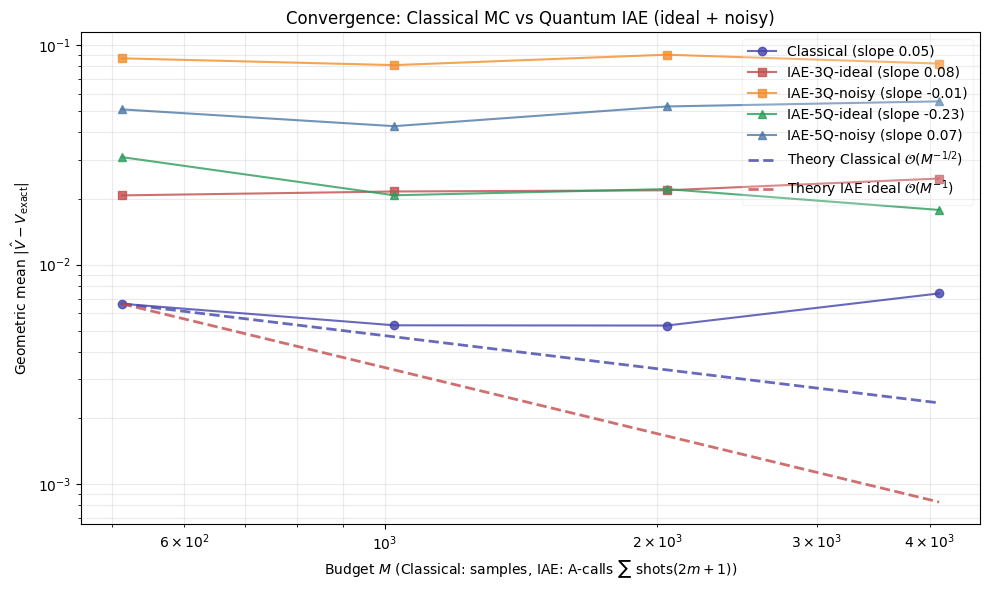

In [35]:
# =========================
# Plot Classical vs Quantum IAE (3q + 5q, ideal + noisy)
#   - Error vs common exact baseline
#   - slope guides: Classical O(M^{-1/2}), Quantum ideal O(M^{-1})
#   - geometric mean |error| per budget (no regression fits for guides)
# Saves: results/convergence_classical_vs_iae.png
# =========================
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import load_jsonl_robust, fit_loglog_slope, slope_curve

IN_PATH = Path("results") / "convergence_classical_vs_iae.jsonl"
if not IN_PATH.exists():
    raise RuntimeError(f"Missing {IN_PATH}. Run the sweep cell first.")

df = load_jsonl_robust(IN_PATH)
if df.empty:
    raise RuntimeError("No rows loaded from sweep file.")

# Type conversions
num_cols = [
    "Estimate",
    "CI Low",
    "CI High",
    "shots",
    "epsilon",
    "budget",
    "trial",
    "timestamp",
    "baseline_exact",
]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
for c in ["family", "mode", "budget_type", "run_tag", "Method"]:
    if c in df.columns:
        df[c] = df[c].astype(str)

required_cols = ["budget", "Estimate", "family"]
df = df.dropna(subset=required_cols)
df = df[df["budget"] > 0].copy()

# One global high-precision classical baseline for *all* methods
if "baseline_exact" not in df.columns or not df["baseline_exact"].notna().any():
    raise RuntimeError("baseline_exact missing; rerun sweep cell.")
baseline_exact = float(df["baseline_exact"].dropna().iloc[-1])
print(f"Global exact baseline: {baseline_exact:.6f}")

def summarize_geo_abs(dfi: pd.DataFrame, baseline: float) -> pd.DataFrame:
    dfi = dfi.copy()
    abs_err = (dfi["Estimate"] - float(baseline)).abs()
    abs_err = abs_err.replace(0, np.nan)
    dfi["log_abs_err"] = np.log(abs_err)
    g = dfi.groupby(["family", "budget"], as_index=False)
    out = (
        g.agg(
            geo_abs=("log_abs_err", lambda s: float(np.exp(np.nanmean(s)))),
            n=("log_abs_err", "count"),
        )
        .sort_values(["family", "budget"])
        .reset_index(drop=True)
    )
    return out

families = [
    "Classical",
    "IAE-3Q-ideal",
    "IAE-3Q-noisy",
    "IAE-5Q-ideal",
    "IAE-5Q-noisy",
]

markers = {
    "Classical": "o",
    "IAE-3Q-ideal": "s",
    "IAE-5Q-ideal": "^",
    "IAE-3Q-noisy": "s",
    "IAE-5Q-noisy": "^",
}
colors = {
    "Classical": "#4444aa",
    "IAE-3Q-ideal": "#c44c4c",
    "IAE-5Q-ideal": "#2c9c5c",
    "IAE-3Q-noisy": "#f28e2b",
    "IAE-5Q-noisy": "#4e79a7",
}

# Only draw theory guides for Classical and ideal 3q
# exponents are positive here; slope_curve uses O(M^-exp)
theory_guides = {"Classical": 0.5, "IAE-3Q-ideal": 1.0}

# Summaries per family vs the common exact baseline
summaries = {}
for fam in families:
    fam_rows = df[df["family"].str.lower() == fam.lower()]
    if fam_rows.empty:
        continue
    summaries[fam] = summarize_geo_abs(fam_rows, baseline_exact)

fig, ax = plt.subplots(figsize=(10, 6))
budgets_all = []

# ---- Plot classical first (also used as anchor for theory lines) ----
M_ref_theory = None
y_ref_theory = None

if "Classical" in summaries:
    sub = summaries["Classical"]
    slope = fit_loglog_slope(
        sub["budget"].to_numpy(), sub["geo_abs"].to_numpy()
    )
    label = (
        "Classical"
        if not np.isfinite(slope)
        else f"Classical (slope {slope:.2f})"
    )
    ax.loglog(
        sub["budget"],
        sub["geo_abs"],
        marker=markers["Classical"],
        linestyle="-",
        label=label,
        color=colors["Classical"],
        alpha=0.8,
    )
    budgets_all.extend(list(sub["budget"].to_numpy()))
    M_ref_theory = float(sub["budget"].iloc[0])
    y_ref_theory = float(sub["geo_abs"].iloc[0])

# ---- Plot quantum families ----
for fam in families:
    if fam == "Classical":
        continue
    if fam not in summaries:
        continue
    s = summaries[fam]
    slope = fit_loglog_slope(
        s["budget"].to_numpy(), s["geo_abs"].to_numpy()
    )
    label = fam if not np.isfinite(slope) else f"{fam} (slope {slope:.2f})"
    ax.loglog(
        s["budget"],
        s["geo_abs"],
        marker=markers.get(fam, "o"),
        linestyle="-",
        label=label,
        color=colors.get(fam, None),
        alpha=0.8,
    )
    budgets_all.extend(list(s["budget"].to_numpy()))

# ---- Theory guides: share the *same* anchor (first classical point) ----
budgets = np.asarray(budgets_all, float)
budgets = budgets[np.isfinite(budgets) & (budgets > 0)]

if budgets.size and M_ref_theory is not None:
    M_min, M_max = float(budgets.min()), float(budgets.max())
    for fam, exp in theory_guides.items():
        M, y = slope_curve(
            M_ref_theory,
            y_ref_theory,
            exponent=exp,
            M_min=M_min,
            M_max=M_max,
        )
        if fam == "Classical":
            guide_label = r"Theory Classical $\mathcal{O}(M^{-1/2})$"
        else:
            guide_label = r"Theory IAE ideal $\mathcal{O}(M^{-1})$"
        ax.loglog(
            M,
            y,
            linestyle="--",
            linewidth=2,
            label=guide_label,
            color=colors.get(fam, None),
            alpha=0.8,
        )

ax.set_xlabel(
    r"Budget $M$ (Classical: samples, IAE: A-calls $\sum$ shots$(2m+1)$)"
)
ax.set_ylabel(r"Geometric mean $|\hat{V} - V_\mathrm{exact}|$")
ax.set_title("Convergence: Classical MC vs Quantum IAE (ideal + noisy)")
ax.grid(True, which="both", alpha=0.25)
ax.legend(loc="upper right", framealpha=0.2, frameon=True)
fig.tight_layout()

out_path = Path("results") / "convergence_classical_vs_iae.png"
fig.savefig(out_path, dpi=220, bbox_inches="tight")
print("Saved:", out_path)
